# XGBoost

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, plot_importance, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score,precision_score,roc_auc_score,recall_score,confusion_matrix
from sklearn.model_selection import train_test_split
import graphviz

## Data Preparation

In [2]:
df = pd.read_csv("datasets/covid_with_y_values.csv", usecols=range(3,30)) #remove 1st to third column

In [3]:
df.head()

,Date,school_closures,international_travel_controls,restriction_gatherings,cancel_public_events,public_information_campaigns,restrictions_internal_movements,income_support,facial_coverings,vaccination_policy,...,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,international_travel_controls_binary,probability_open
0,1/6/2020,3,3,4,2,2,2,0,1,0,...,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,0,0.923077
1,8/6/2020,3,3,4,2,2,2,0,3,0,...,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,0,1.000000
2,15/6/2020,3,1,4,2,2,2,0,3,0,...,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,1.000000
3,22/6/2020,3,1,4,2,2,2,0,3,0,...,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,1.000000
4,29/6/2020,3,1,4,2,2,2,0,3,0,...,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,1.000000


## Select NA values for prediction and evaluation

In [4]:
data_topredict = pd.read_csv("datasets/covid_with_y_values.csv") #cleaned dataset

In [5]:
data_topredict = data_topredict[data_topredict["probability_open"].isna()] #to be used once model is done

In [6]:
data_topredict.head()

,Unnamed: 0,Entity,Code,Date,school_closures,international_travel_controls,restriction_gatherings,cancel_public_events,public_information_campaigns,restrictions_internal_movements,...,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,international_travel_controls_binary,probability_open
45,45,Afghanistan,AFG,12/4/2021,0,1,0,2,1,0,...,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,NaN
46,46,Afghanistan,AFG,19/4/2021,0,1,0,2,1,0,...,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,NaN
47,47,Afghanistan,AFG,26/4/2021,0,1,0,2,1,0,...,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,NaN
48,48,Afghanistan,AFG,3/5/2021,0,1,0,2,1,0,...,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,NaN
49,49,Afghanistan,AFG,10/5/2021,0,1,0,2,1,0,...,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,NaN


## Give categorical label for probability > 0.5

In [7]:
df.dropna(inplace = True) #remove all the "to_predict" (NA values)

In [8]:
conditions = [(df["probability_open"] < 0.5), (df["probability_open"]>= 0.5)] #categorise probability_open for labelling
values = [0, 1]

df["label"] = np.select(conditions, values) #if else condition for label

In [9]:
df.label.value_counts() #check for unbalanced dataset -> 42% y=1

0    3771
1    2754
Name: label, dtype: int64

In [10]:
df.to_csv(r"C:\Users\kaiyit.KKY\OneDrive - National University of Singapore\NUS Mods\Y3S1\DSA3101 Data Science in Practice\Assignment 1\cleaned datasets\data_with_label.csv")

## Dataset for model training

In [11]:
allcols = df.columns.tolist() #get column names
feature_cols = allcols.copy()
feature_cols.remove("probability_open") #remove due to multicollinearity
feature_cols.remove("label") #remove response variable
feature_cols.remove("Date") #remove date which is not a feature in the model

print(feature_cols)

['school_closures', 'international_travel_controls', 'restriction_gatherings', 'cancel_public_events', 'public_information_campaigns', 'restrictions_internal_movements', 'income_support', 'facial_coverings', 'vaccination_policy', 'testing_policy', 'contact_tracing', 'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 'new_vaccinations_smoothed_per_million', 'population', 'population_density', 'median_age', 'aged_65_older', 'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence', 'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'international_travel_controls_binary']


In [12]:
y = df["label"] #get response variable
x = df[feature_cols] #get features

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 3, stratify = y)

In [13]:
y_train.value_counts() #training dataset is balanced at approximately 42% for y=1

0    3017
1    2203
Name: label, dtype: int64

In [14]:
y_test.value_counts() #test dataset is balanced at approximately 42% for y=1

0    754
1    551
Name: label, dtype: int64

#### XGBoost Model functions

In [15]:
def model_xgb(early):
    model = XGBClassifier(use_label_encoder = False)
    eval_set = [(X_train, y_train), (X_test, y_test)] #evaluation set
    model.fit(X_train, y_train, early_stopping_rounds = early, eval_metric = ["error", "logloss"], 
              eval_set = eval_set, verbose = False) #fit training set
    
    print("Training Set Evaluation")
    y_pred_train = model.predict(X_train) #predict for training set
    
    cm = pd.DataFrame(confusion_matrix(y_pred_train, y_train)) #confusion matrix for training set
    cm.columns = ['True Y=0','True Y=1']
    cm.index = ['Predicted Y=0','Predicted Y=1']
    display(cm)
    
    specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0]) #calculate specificity
    
    #calculate and print the rest
    print("Accuracy (Training set):",round(accuracy_score(y_train, y_pred_train),4))
    print('Precision (Training set):', round(precision_score(y_train, y_pred_train),4))
    print('Specificity (Training set):', round(specificity,4))
    print('Sensitivity (Training set)',round(recall_score(y_train,y_pred_train),4))
    print('F1-Score (Training set):', round(f1_score(y_train,y_pred_train),4))
    print('AUC (Training set):',round(roc_auc_score(y_train, y_pred_train),4))
    
    print("\n")
    print("Test Set Evaluation")
    y_pred_test = model.predict(X_test) #predict for test set
    cm_test = pd.DataFrame(confusion_matrix(y_pred_test, y_test)) #confusion matrix for test set
    cm_test.columns = ['True Y=0','True Y=1']
    cm_test.index = ['Predicted Y=0','Predicted Y=1']
    display(cm_test)
    
    specificity_test = cm_test.iloc[0, 0]/(cm_test.iloc[0, 0] + cm_test.iloc[1, 0]) #calculate specificity
    
    #calculate and print the rest
    print("Accuracy (Test set):",round(accuracy_score(y_test, y_pred_test),4))
    print('Precision (Test set):', round(precision_score(y_test, y_pred_test),4))
    print('Specificity (Test set):', round(specificity_test,4))
    print('Sensitivity (Test set)',round(recall_score(y_test,y_pred_test),4))
    print('F1-Score (Test set):', round(f1_score(y_test,y_pred_test),4))
    print('AUC (Test set):',round(roc_auc_score(y_test, y_pred_test),4))
    
    return model

#### XGBoost Model Plots

In [16]:
def model_eval(model, log_filename, error_filename):
    print("Model Evaluation")
    
    # retrieve performance metrics from fitted model
    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
    
    # plot log loss
    fig, ax = plt.subplots(figsize=(12,12))
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    
    #add axis
    plt.ylabel('Log Loss')
    plt.xlabel("Epochs")
    plt.title('XGBoost Log Loss')
    plt.show()
    
    # plot classification error
    fig2, ax = plt.subplots(figsize=(12,12))
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()
    
    #add axis
    plt.ylabel('Classification Error')
    plt.xlabel("Epochs")
    plt.title('XGBoost Classification Error')
    plt.show()

### Model 1

In [17]:
#using default parameters, early_stopping_rounds=10
model = model_xgb(10)

Training Set Evaluation


,True Y=0,True Y=1
Predicted Y=0,3007,9
Predicted Y=1,10,2194


Accuracy (Training set): 0.9964
Precision (Training set): 0.9955
Specificity (Training set): 0.9967
Sensitivity (Training set) 0.9959
F1-Score (Training set): 0.9957
AUC (Training set): 0.9963


Test Set Evaluation


,True Y=0,True Y=1
Predicted Y=0,720,40
Predicted Y=1,34,511


Accuracy (Test set): 0.9433
Precision (Test set): 0.9376
Specificity (Test set): 0.9549
Sensitivity (Test set) 0.9274
F1-Score (Test set): 0.9325
AUC (Test set): 0.9412


Model Evaluation


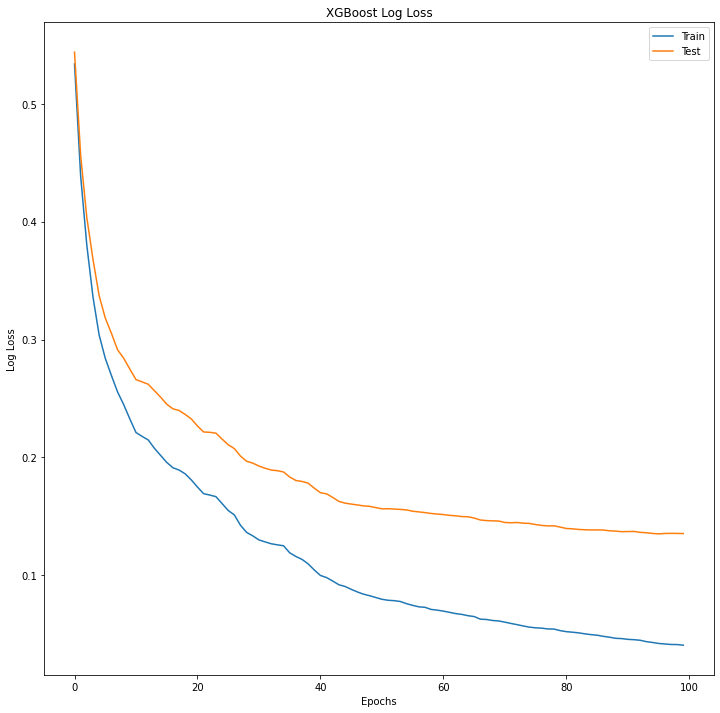

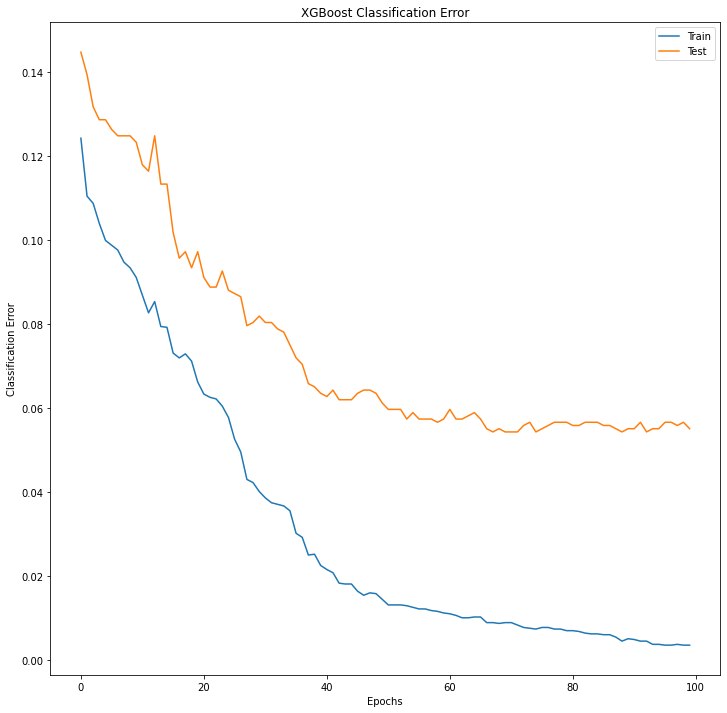

In [18]:
model_eval(model, "early_10_log", "early_10_error")

## Feature Importance of Model 1

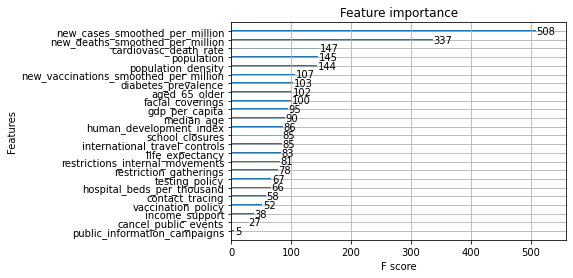

In [19]:
fig3 = plot_importance(model) #show feature importance
plt.show()

## Tree diagram for model 1

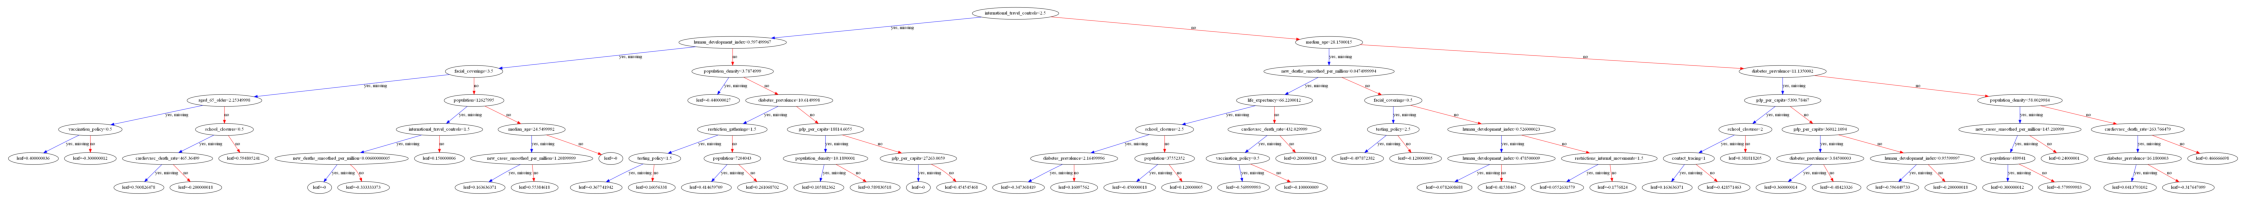

In [20]:
fig4 = plt.figure(figsize = (40, 20))
plot_tree(model, ax = plt.gca()) #get tree
fig4.savefig('C:\\Users\\kaiyit.KKY\\OneDrive - National University of Singapore\\NUS Mods\\Y3S1\\DSA3101 Data Science in Practice\\Assignment 1\\xgboost_dt.png')

From the feature importance, we can try to drop "public_information_campaigns" (lowest significance). 

In [21]:
feature_cols.remove("public_information_campaigns") #remove insignificant variables
y = df["label"]
x = df[feature_cols]

#resplitting train and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 3, stratify = y)

## Model 2

In [22]:
model2 = model_xgb(10) #refit model

Training Set Evaluation


,True Y=0,True Y=1
Predicted Y=0,3006,8
Predicted Y=1,11,2195


Accuracy (Training set): 0.9964
Precision (Training set): 0.995
Specificity (Training set): 0.9964
Sensitivity (Training set) 0.9964
F1-Score (Training set): 0.9957
AUC (Training set): 0.9964


Test Set Evaluation


,True Y=0,True Y=1
Predicted Y=0,727,39
Predicted Y=1,27,512


Accuracy (Test set): 0.9494
Precision (Test set): 0.9499
Specificity (Test set): 0.9642
Sensitivity (Test set) 0.9292
F1-Score (Test set): 0.9394
AUC (Test set): 0.9467


Model Evaluation


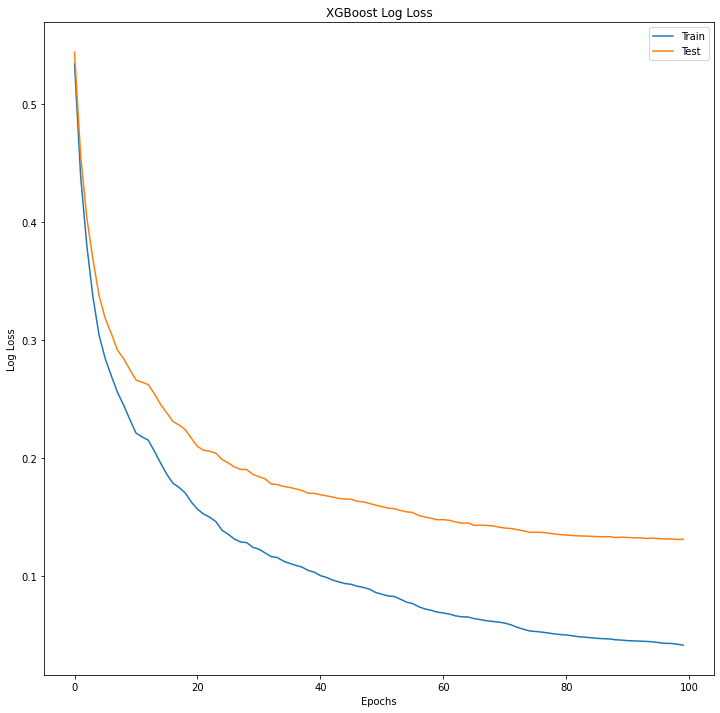

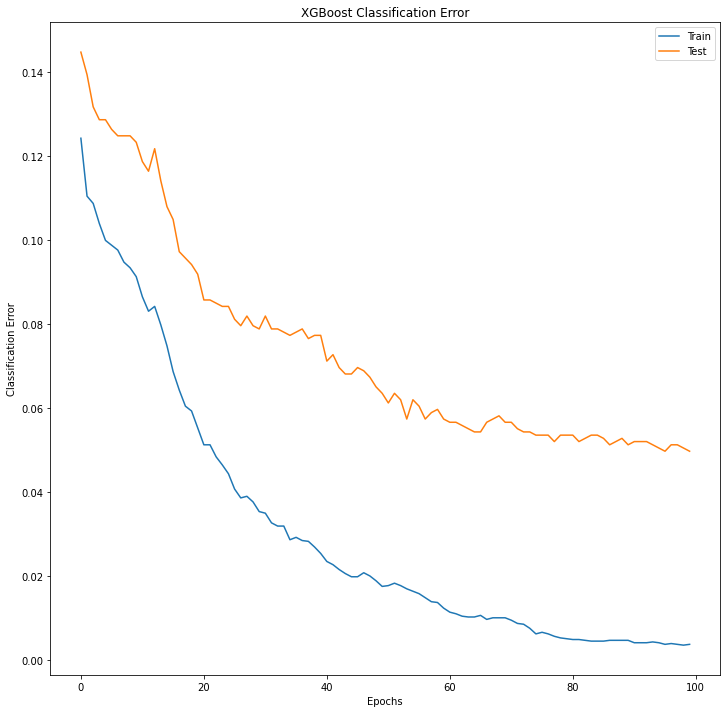

In [23]:
model_eval(model2, "remove_log", "remove_error")

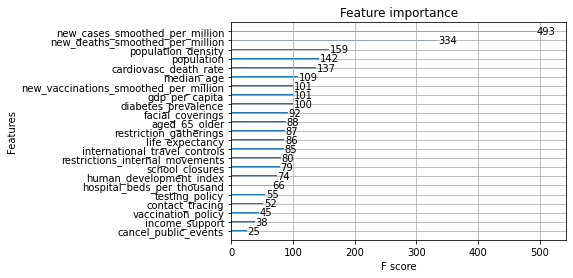

In [24]:
fig5 = plot_importance(model2) #feature importance
plt.show()

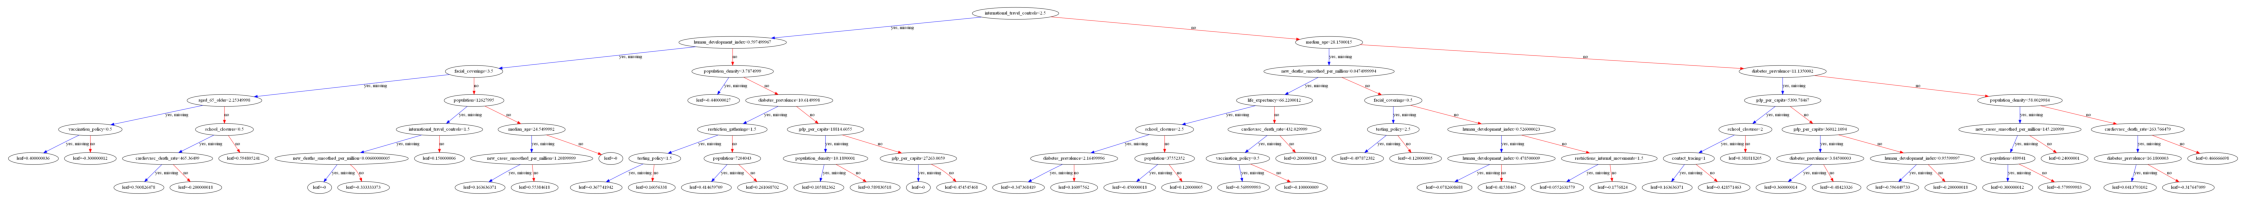

In [25]:
fig6 = plt.figure(figsize = (40, 20))
plot_tree(model2, ax = plt.gca()) #get tree
fig6.savefig('C:\\Users\\kaiyit.KKY\\OneDrive - National University of Singapore\\NUS Mods\\Y3S1\\DSA3101 Data Science in Practice\\Assignment 1\\xgboost_dt_removed.png')

## Predict data using model 2

In [26]:
x_predict = data_topredict[feature_cols] #get columns used in model

In [27]:
prediction = model2.predict(x_predict) #predict

In [28]:
data_topredict.insert(30, "label", prediction) #add to dataframe

In [29]:
data_topredict["label"].value_counts()

0    1011
1     868
Name: label, dtype: int64

In [30]:
data_topredict.head()

,Unnamed: 0,Entity,Code,Date,school_closures,international_travel_controls,restriction_gatherings,cancel_public_events,public_information_campaigns,restrictions_internal_movements,...,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,international_travel_controls_binary,probability_open,label
45,45,Afghanistan,AFG,12/4/2021,0,1,0,2,1,0,...,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,NaN,1
46,46,Afghanistan,AFG,19/4/2021,0,1,0,2,1,0,...,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,NaN,1
47,47,Afghanistan,AFG,26/4/2021,0,1,0,2,1,0,...,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,NaN,1
48,48,Afghanistan,AFG,3/5/2021,0,1,0,2,1,0,...,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,NaN,1
49,49,Afghanistan,AFG,10/5/2021,0,1,0,2,1,0,...,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,NaN,1


In [31]:
#export to csv
data_topredict.to_csv(r"C:\Users\kaiyit.KKY\OneDrive - National University of Singapore\NUS Mods\Y3S1\DSA3101 Data Science in Practice\Assignment 1\cleaned datasets\data_topredict.csv")

## Predict 2nd August's Data using model 2

In [32]:
aug_2 = pd.read_csv("datasets/2aug.csv")
aug_2_prediction = aug_2[feature_cols] #get columns used in model

In [33]:
prediction2 = model2.predict(aug_2_prediction) #predict 2nd august

In [34]:
aug_2.insert(29, "label", prediction2) #add to dataframe

In [39]:
aug_2 = aug_2.iloc[: , 1:]
aug_2.head()

,Entity,Code,Date,school_closures,international_travel_controls,restriction_gatherings,cancel_public_events,public_information_campaigns,restrictions_internal_movements,income_support,...,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,international_travel_controls_binary,label
0,Afghanistan,AFG,2021-08-02,2,1,4,2,1,1,0,...,18.6,2.581,1803.987,597.029,9.59,0.50,64.83,0.511,1,1
1,Albania,ALB,2021-08-02,2,0,3,1,1,0,1,...,38.0,13.188,11803.431,304.195,10.08,2.89,78.57,0.795,1,1
2,Argentina,ARG,2021-08-02,2,4,4,2,2,2,1,...,31.9,11.198,18933.907,191.032,5.50,5.00,76.67,0.845,0,0
3,Australia,AUS,2021-08-02,2,4,4,2,2,2,0,...,37.9,15.504,44648.710,107.791,5.07,3.84,83.44,0.944,0,0
4,Austria,AUT,2021-08-02,2,3,2,1,2,0,2,...,44.4,19.202,45436.686,145.183,6.35,7.37,81.54,0.922,0,0


In [40]:
aug_2["label"].value_counts()

1    68
0    64
Name: label, dtype: int64

In [41]:
#export to csv
aug_2.to_csv(r"C:\Users\kaiyit.KKY\OneDrive - National University of Singapore\NUS Mods\Y3S1\DSA3101 Data Science in Practice\Assignment 1\cleaned datasets\aug2_topredict.csv")